In this notebook we'll create a toy river flow forecasting problem.

We assume that the river instantaneous flow at time is mainly driven by two factors:

* The melting rate of an upstream glacier $t-5$ days ago.
* The rainfalls during the last $5$ days.
We want to forecast the flow $10$ days in advance.

Furthermore, we assume that:

* The glacier's melting rate is not known in advance because it has to be measured; it is thus a past covariate.
* The rainfall is known $10$ time steps in advance. It is thus technically a future covariate.

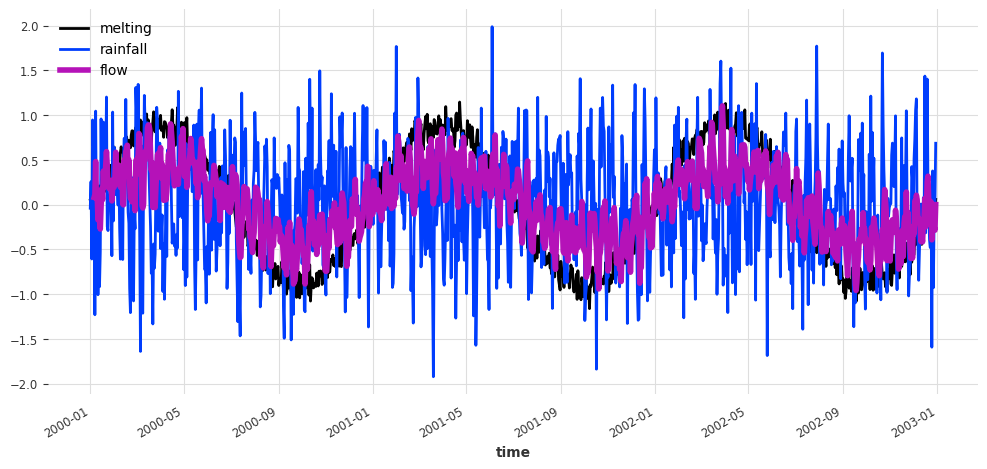

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from darts.utils import timeseries_generation as tg

np.random.seed(42)

LENGTH = 3 * 365  # 3 years of daily data

# Melting: a sine with yearly periodicity and additive white noise
melting = (0.9 * tg.sine_timeseries(length=LENGTH, value_frequency=(1/365), 
                              freq='D', 
                              column_name='melting')
           + 0.1 * tg.gaussian_timeseries(length=LENGTH, freq='D'))

# Rainfalls: a sine with bi-weekly periodicity and additive white noise
rainfalls = (0.5 * tg.sine_timeseries(length=LENGTH, 
                                value_frequency=(1/14), 
                                freq='D', 
                                column_name='rainfall')
             + 0.5 * tg.gaussian_timeseries(length=LENGTH, freq='D'))

# We shift the melting by 5 days
melting_contribution = 0.5 * melting.shift(5)

# We compute similar contribution from the rainfalls
all_contributions = [melting_contribution] + [0.1 * rainfalls.shift(lag) for lag in range(5)]

# We compute the final flow as the sum of everything; trimming series so they
# all have the same start time
flow = sum([series[melting_contribution.start_time():][:melting.end_time()]
            for series in all_contributions]).with_columns_renamed('melting', 'flow')

# add some white noise
flow += 0.1 * tg.gaussian_timeseries(length=len(flow))

plt.figure(figsize=(12,5))
melting.plot()
rainfalls.plot()
flow.plot(lw=4)

In [5]:
from darts.metrics import rmse

# We first set aside the first 80% as training series:
flow_train, _ = flow.split_before(0.8)

def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=flow, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=False, 
                                          forecast_horizon=10)
    
    flow[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(flow, backtest)))

In [10]:
flow_train

<TimeSeries (DataArray) (time: 871, component: 1, sample: 1)>
array([[[ 0.07945644]],

       [[ 0.1127387 ]],

       [[ 0.48123095]],

       [[ 0.07075233]],

       [[ 0.09616017]],

       [[-0.17101855]],

       [[ 0.14115837]],

       [[-0.12858771]],

       [[-0.27302378]],

       [[-0.02243861]],

...

       [[ 0.2369816 ]],

       [[ 0.29645405]],

       [[ 0.2728519 ]],

       [[ 0.48619629]],

       [[ 0.32809247]],

       [[ 0.45024041]],

       [[ 0.56004237]],

       [[ 0.4271422 ]],

       [[ 0.59865186]],

       [[ 0.5409956 ]]])
Coordinates:
  * time       (time) datetime64[ns] 2000-01-06 2000-01-07 ... 2002-05-25
  * component  (component) object 'flow'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

# no covariates

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 312.54it/s, train_loss=0.0325]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 310.78it/s, train_loss=0.0325]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), us

Backtest RMSE = 0.2014189567338487


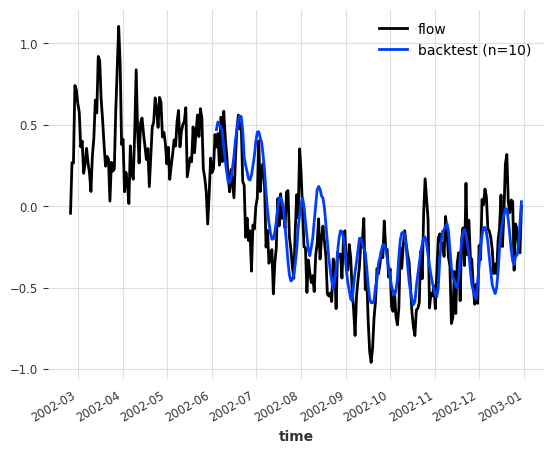

In [6]:
from darts.models import BlockRNNModel

brnn_no_cov = BlockRNNModel(input_chunk_length=30, 
                            output_chunk_length=10, 
                            n_rnn_layers=2)

brnn_no_cov.fit(flow_train, 
                epochs=100, 
                verbose=True
                )

eval_model(brnn_no_cov)

# Past covariates (melting)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 260   
---------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 252.25it/s, train_loss=0.0226]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 251.18it/s, train_loss=0.0226]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), us

Backtest RMSE = 0.17222345433573383


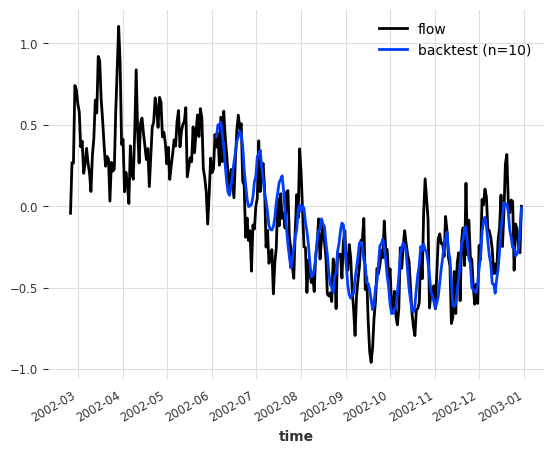

In [7]:
brnn_melting = BlockRNNModel(input_chunk_length=30, 
                             output_chunk_length=10, 
                             n_rnn_layers=2)

brnn_melting.fit(flow_train, 
                 past_covariates=melting, 
                 epochs=100, 
                 verbose=True)

eval_model(brnn_melting, 
           past_covariates=melting)

# Past covariates (melting and rainfall)

In [ ]:
brnn_melting_and_rain = BlockRNNModel(input_chunk_length=30, 
                                      output_chunk_length=10, 
                                      n_rnn_layers=2)

brnn_melting_and_rain.fit(flow_train, 
                          past_covariates=melting.stack(rainfalls), 
                          epochs=100, 
                          verbose=True)

eval_model(brnn_melting_and_rain, 
           past_covariates=melting.stack(rainfalls))

# future covariates (rainfall)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 172.74it/s, train_loss=0.013] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 172.21it/s, train_loss=0.013]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), us

Backtest RMSE = 0.14607996540803786


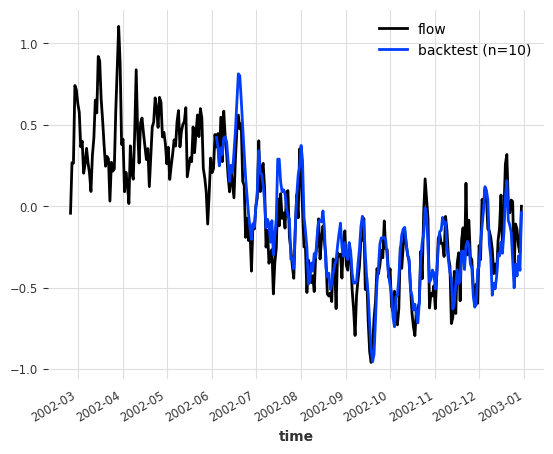

In [11]:
from darts.models import RNNModel

rnn_rain = RNNModel(input_chunk_length=30, 
                    training_length=40, 
                    n_rnn_layers=2)

rnn_rain.fit(flow_train, 
             future_covariates=rainfalls, 
             epochs=100, 
             verbose=True)

eval_model(rnn_rain, 
           future_covariates=rainfalls)

# Cheating

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
2.1 K     Trainable params
0         Non-trainable params
2.1 K     Total params
0.008     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 172.16it/s, train_loss=0.00948]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 26/26 [00:00<00:00, 171.68it/s, train_loss=0.00948]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), us

Backtest RMSE = 0.10612201273966912


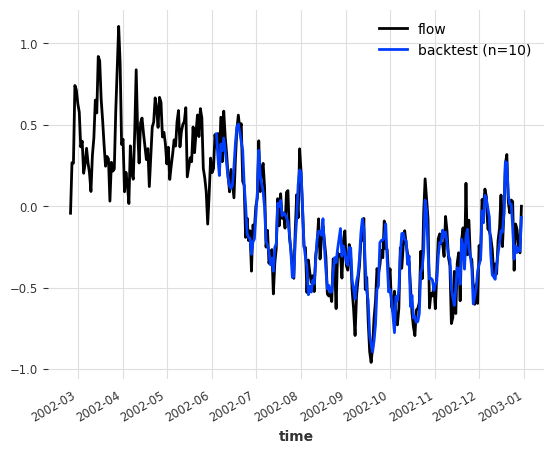

In [14]:
rnn_melting_and_rain = RNNModel(input_chunk_length=30, 
                                training_length=40, 
                                n_rnn_layers=2)

rnn_melting_and_rain.fit(flow_train, 
                         future_covariates=melting.stack(rainfalls), 
                         epochs=100, 
                         verbose=True)

eval_model(rnn_melting_and_rain, 
           future_covariates=melting.stack(rainfalls))

The lags of the target and past covariates have to be strictly negative (in the past), whereas the lags of the future covariates can also be positive (in the future). For instance, a lag value of -5 means that the value at time t-5 is used to predict the target at time t; and a lag of 0 means that the future covariate value at time t is used to predict the target at time t. In the code below, we specify past covariate lags as [-5, -4, -3, -2, -1] which means that the model will look at the last 5 past_covariates values (we could also have specified lags_past_covariates=5 instead). Similarly, we specify the future covariate lags as [-4, -3, -2, -1, 0] which means that the model will look at the last 4 historic values (lags -4 to -1) and the current value (lag 0) of the future_covariates. (we could also have specified lags_future_covariates=(4,1) instead). Note that we do not specify any lags here, which means that this model won’t look at past values of the target at all — it will look at covariates only.

Backtest RMSE = 0.10185261915286314


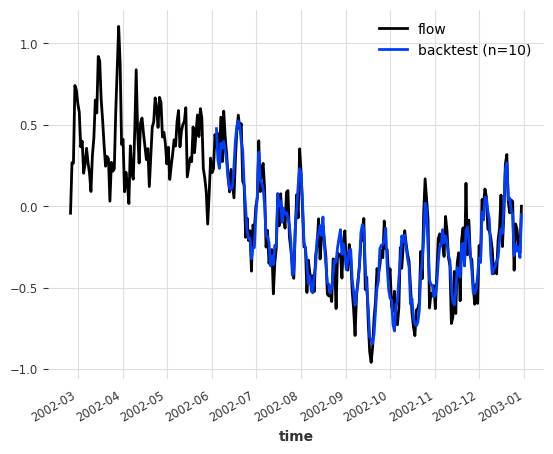

In [33]:
from darts.models import RegressionModel
from darts.dataprocessing.transformers import Scaler
regr_model = RegressionModel(lags=None,
                             lags_past_covariates=[-5, -4, -3, -2, -1], 
                             lags_future_covariates=[-5, -4, -3, -2, -1, 0],
                             add_encoders={'transformer': Scaler()})


regr_model.fit(flow_train,
               past_covariates=melting,
               future_covariates=rainfalls)

eval_model(regr_model)

Backtest RMSE = 0.14335916866334145


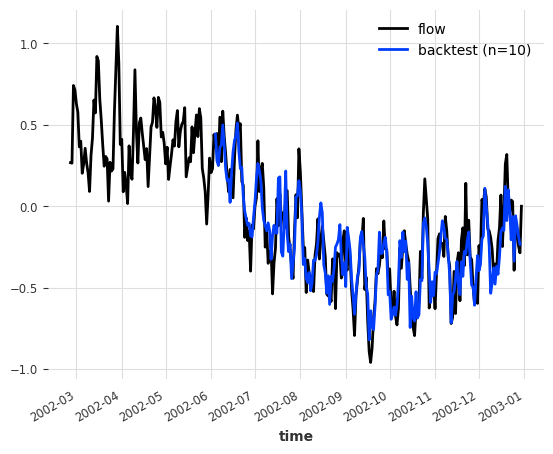

In [36]:
from darts.models import RegressionModel
from darts.models import RandomForest
from darts.models import LightGBMModel
from darts.dataprocessing.transformers import Scaler

regr_model = LightGBMModel( lags=None,
                             lags_past_covariates=[-5, -4, -3, -2, -1], 
                             lags_future_covariates=[-3, -2, -1, 0, 1],
                             add_encoders={'transformer': Scaler()})


regr_model.fit(flow_train,
               past_covariates=melting,
               future_covariates=rainfalls)

eval_model(regr_model)

# Resources

* https://unit8co.github.io/darts/examples/04-RNN-examples.html
* https://medium.com/unit8-machine-learning-publication/time-series-forecasting-using-past-and-future-external-data-with-darts-1f0539585993